<a href="https://colab.research.google.com/github/Prajakta2706/Final-year-project-/blob/main/Final_Project_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Pneumonia Detection using CNN with Implementation in Python**

In [ ]:
# Mounting the google drive for Dataset access
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#preparing to download the data from kaggle to Google Drive
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [ ]:
#changing the working directory
%cd /content/gdrive/MyDrive/Kaggle

/content/gdrive/MyDrive/Kaggle


In [ ]:
#Downloading the Dataset from Kaggle to Google Drive
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#unzipping the downloaded data
!unzip \*.zip

Archive:  chest-xray-pneumonia.zip
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#changing working directory 
%cd /content/gdrive/MyDrive/Kaggle1/chest_xray/

/content/gdrive/MyDrive/Kaggle1/chest_xray


##Loading the Modules and train Images

---


The very first thing to do when working with a computer vision project is to load all required modules and the image data itself. I use tqdm module to display the progress bar which you’ll see why it is useful later on. The last import I do here is ImageDataGenerator coming from the Keras module. This module is going to help us with implementing the image augmentation technique during the training process.


In [ ]:
import os
from cv2 import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
np.random.seed(22)

Next, I define two functions to load image data from each folder. The two functions below might look identical at glance, but there’s actually a little difference at the line with bold text. This is done because the filename structure in NORMAL and PNEUMONIA folders are slightly different. Despite the difference, the other process done by both functions is essentially the same. First, all images are going to be resized to 200 by 200 pixels large.

  This is important to do since the images in all folders are having different dimensions while the neural networks can only accept data with a fixed array size. Next, basically all images are stored with 3 color channels, which is I think it’s just redundant for x-ray images. So the idea here is to convert all those color images to grayscale.

In [ ]:
def load_normal(norm_path):
    norm_files = np.array(os.listdir(norm_path))
    norm_labels = np.array(['normal']*len(norm_files))
    
    norm_images = []
    for image in tqdm(norm_files):
        image = cv2.imread(norm_path + image)
        image = cv2.resize(image, dsize=(200,200))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        norm_images.append(image)
        
    norm_images = np.array(norm_images)
    
    return norm_images, norm_labels

    
def load_pneumonia(pneu_path):
    pneu_files = np.array(os.listdir(pneu_path))
    pneu_labels = np.array([pneu_file.split('_')[1] for pneu_file in pneu_files])
    
    pneu_images = []
    for image in tqdm(pneu_files):
        image = cv2.imread(pneu_path + image)
        image = cv2.resize(image, dsize=(200,200))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        pneu_images.append(image)
        
    pneu_images = np.array(pneu_images)
    
    return pneu_images, pneu_labels

As the two functions above have been declared, now we can just use it to load train data.

In [ ]:
norm_images, norm_labels = load_normal('train/NORMAL/')

100%|██████████| 1341/1341 [10:53<00:00,  2.05it/s]


In [ ]:
pneu_images, pneu_labels = load_pneumonia('train/PNEUMONIA/')

100%|██████████| 3875/3875 [22:47<00:00,  2.83it/s]


Up to this point, we already got several arrays: norm_images, norm_labels, pneu_images, and pneu_labels. The one with _images suffix indicates that it contains the preprocessed images while the array with _labels suffix shows that it stores all ground truths (a.k.a. labels). In other words, both norm_images and pneu_images are going to be our X data while the rest is going to be y data. To make things look more straightforward, I concatenate the values of those arrays and store in X_train and y_train array.

In [ ]:
X_train = np.append(norm_images, pneu_images, axis=0)
y_train = np.append(norm_labels, pneu_labels)

Showing the shape of train data.
That is the shape of the features (X) and labels (y).

In [ ]:
X_train.shape

(5216, 200, 200)

In [ ]:
y_train.shape

(5216,)

Finding out the number of unique values in our Dataset..

In [ ]:
np.unique(y_train, return_counts=True)

(array(['bacteria', 'normal', 'virus'], dtype='<U8'),
 array([2530, 1341, 1345]))

##Displaying Several images

---


The code below is used to display 14 images taken randomly from X_train array along with the labels. This is not mandatory at all but i used it to make sure that the images are loaded

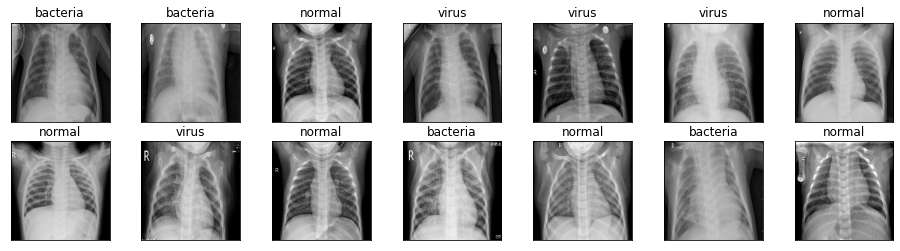

In [ ]:
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(16, 4))

indices = np.random.choice(len(X_train), 14)
counter = 0

for i in range(2):
    for j in range(7):
        axes[i,j].set_title(y_train[indices[counter]])
        axes[i,j].imshow(X_train[indices[counter]], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        counter += 1
plt.show()



We can see the figure above that all images are now having the exact same size.

##Loading Test images

---



As we already know that all train data have been loaded successfully, we can now use the exact same function to load our test data. The steps are pretty much the same, but here I store those loaded data in X_test and y_test array. The data used for testing itself contains 624 samples

In [ ]:
norm_images_test, norm_labels_test = load_normal('test/NORMAL/')
pneu_images_test, pneu_labels_test = load_pneumonia('test/PNEUMONIA/')
X_test = np.append(norm_images_test, pneu_images_test, axis=0)
y_test = np.append(norm_labels_test, pneu_labels_test)

100%|██████████| 390/390 [02:17<00:00,  2.83it/s]


Furthermore, I noticed that it takes pretty long just to load the entire dataset. Hence I will save X_train, X_test, y_train, and y_test in a separate file using pickle module. So that I don’t need to repeat running the codes above next time I want to use these data again.

In [ ]:
#with open('pneumonia_data.pickle', 'wb') as f:
#    pickle.dump((X_train, X_test, y_train, y_test), f)# Use this to load variables
with open('pneumonia_data.pickle', 'rb') as f:
    (X_train, X_test, y_train, y_test) = pickle.load(f)

Since all X data have been preprocessed well, now it’s time to work with labels y_train and y_test.

##Label Preprocessing

---



At this point, both y variables consist of either normal, bacteria, or virus written in string datatype. In fact, such labels are just not acceptable by neural networks. Therefore, we need to convert that into a one-hot format. Luckily we got the OneHotEncoder object taken from Scikit-Learn module which is extremely helpful to do the conversion. In order to do that, we need to begin with creating a new axis on both y_train and y_test. (We create this new axis since that’s just the shape expected by OneHotEncoder)

In [ ]:
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]

Now to make this categorical Data more expressive we will use OneHotEncoder like this..

In [ ]:
one_hot_encoder = OneHotEncoder(sparse=False)

Finally, we are going to use this one_hot_encoder to actually convert these y data into one-hot. The encoded labels are then stored in y_train_one_hot and y_test_one_hot. These two arrays are the labels that we will use for the training.

In [ ]:
y_train_one_hot = one_hot_encoder.fit_transform(y_train)
y_test_one_hot = one_hot_encoder.transform(y_test)

##Reshaping the X data 

---



Now let’s get back to our X_train and X_test. It’s important to know that the shape of these two arrays are (5216, 200, 200) and (624, 200, 200) respectively. Well, at glance, these two shapes look fine as we can just display that using plt.imshow() function. However,  this shape is just not acceptable by the convolution layer since it expects a color channel to be included as its input.

Thus, since this image is essentially colored in grayscale, then we need to add a new axis with 1 dimension which is going to be recognized by the convolution layer as the only color channel.

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

Now after running the code above, if we check the shape of both X_train and X_test, then we will see that the shape is now (5216, 200, 200, 1) and (624, 200, 200, 1) respectively.

##Data Augmentation

---



The main point of augmenting data — or more specifically augmenting train data is that we are going to increase the number of data used for training by creating more samples with some sort of randomness on each of them. These randomnesses might include translations, rotations, scaling, shearing, and flips.

Such a technique is able to help our neural network classifier to reduce overfitting, or in other words, it can make the model generalize data samples better. Luckily, the implementation is very easy thanks to the existence of ImageDataGenerator object which can be imported from the Keras module.

In [ ]:
datagen = ImageDataGenerator(
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

So what I essentially done in the code above is to set the range of randomness. Here’s a [link to the documentation](https://keras.io/api/preprocessing/image/) of ImageDataGenerator if you wanna know the details of each argument. Next, what we need to do after initializing the datagen object is to fit it with our X_train. This process is then followed by applying the flow() method in which this step is useful such that the train_gen object is now able to generate batches of augmented data.

In [ ]:
datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train_one_hot, batch_size=32)

##CNN Convolutional Neural Network

---



Now it’s time to actually build the neural network architecture. Let’s start with the input layer (input1). So this layer basically takes all the image samples in our X data. Hence we need to ensure that the first layer accepts the exact same shape as the image size. It’s worth noting that what we need to define is only (width, height, channels), instead of (samples, width, height, channels).

Afterward, this input1 layer is connected to several convolution-pooling layer pairs before eventually being flattened and connected to dense layers. Notice that all hidden layers in the model are using the ReLU activation function due to the fact that ReLU is faster to compute compared to sigmoid, and thus, the training time required is shorter. Lastly, the last layer to connect is output1, which consists of 3 neurons with a softmax activation function.

Here softmax is used because we want the outputs to be the probability value of each class

In [ ]:
input1 = Input(shape=(X_train.shape[1], X_train.shape[2], 1))
#Convolution Operation
cnn = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), 
    padding='same')(input1)
cnn = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)

cnn = Conv2D(16, (2, 2), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = Conv2D(32, (2, 2), activation='relu', strides=(1, 1), 
    padding='same')(cnn)

#Pooling Operation
cnn = MaxPool2D((2, 2))(cnn)

#Flattening Operation
cnn = Flatten()(cnn)

#Fully Connected Layer
cnn = Dense(100, activation='relu')(cnn)
cnn = Dense(50, activation='relu')(cnn)
output1 = Dense(3, activation='softmax')(cnn)

model = Model(inputs=input1, outputs=output1)

After constructing the neural network using the code above, we can display the summary of our model by applying the summary() to the model object. Below is how our CNN model looks like in detail. We can see here that we got 8 million params in total — which is a lot.

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 200, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 32)      4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 16)      2064      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 100, 32)      2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0     

After the model being constructed, now we need to compile the neural net using a categorical cross-entropy loss function and Adam optimizer. So this loss function is used since it’s just the one that’s commonly used in the multiclass classification task. Meanwhile, I choose Adam as the optimizer since it’s just the best one to minimize loss value in most neural network tasks.

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['acc'])

Now it’s time to train the model! Here we are going to use fit_generator() instead of fit() because we are going to take the train data from the train_gen object. If you pay attention to the data augmentation part, you’ll notice that train_gen is created using both X_train and y_train_one_hot. Therefore, we don’t need to explicitly define the X-y pairs in the fit_generator() method.

What’s so special with train_gen is that the training process is going to be done using samples with some randomness. So all training data that we have in X_train is not directly fed into the neural network. Instead, those samples are going to be used as the basis of the generator to generate a new image with some random transformations.

Moreover, this generator produces different images in each epoch which is extremely good for our neural network classifier to better generalize samples in the test set. And well, below is how the training process goes.

In [ ]:
history = model.fit_generator(train_gen, epochs=30, 
          validation_data=(X_test, y_test_one_hot))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
163/163 [==============================] - 58s 94ms/step - loss: 8.8243 - acc: 0.5496 - val_loss: 1.0474 - val_acc: 0.5962
Epoch 2/30
163/163 [==============================] - 15s 90ms/step - loss: 0.7201 - acc: 0.6907 - val_loss: 0.9317 - val_acc: 0.6603
Epoch 3/30
163/163 [==============================] - 15s 90ms/step - loss: 0.6288 - acc: 0.7311 - val_loss: 0.9311 - val_acc: 0.6699
Epoch 4/30
163/163 [==============================] - 15s 90ms/step - loss: 0.6211 - acc: 0.7372 - val_loss: 0.9089 - val_acc: 0.6939
Epoch 5/30
163/163 [==============================] - 15s 89ms/step - loss: 0.6166 - acc: 0.7263 - val_loss: 0.7513 - val_acc: 0.7324
Epoch 6/30
163/163 [==============================] - 15s 89ms/step - loss: 0.5962 - acc: 0.7507 - val_loss: 0.8210 - val_acc: 0.7003
Epoch 7/30
163/163 [==============================] - 15s 90ms/step - loss: 0.5688 - acc: 0.7627 - val_loss: 0.6565 - val_acc: 0.7901
Epoch 8/30
163/163 [==============================] - 15s 89ms

After being trained, we can plot the improvement of accuracy score and the decrease of loss value like this:

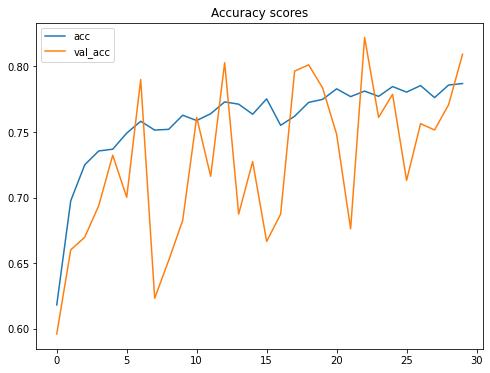

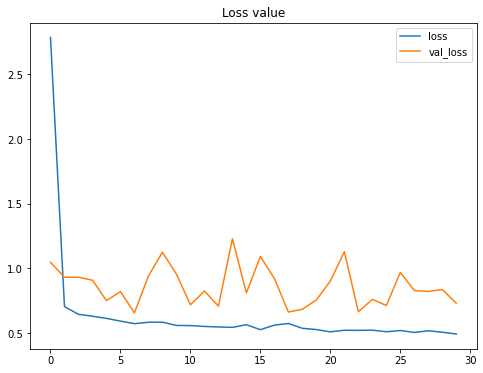

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.show()
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

According to the two figures above, we can say that the performance of the model keeps improving, even though both the testing accuracy and loss value look fluctuating within these 30 epochs. Another important thing to notice here is that this model does not suffer from overfitting thanks to the data augmentation method we applied in the earlier part of this project. We can see here that the accuracy on train and test data is 79% and 80% respectively at the final iteration

To reduce the hassle of training the model again and again.. We save model weights to a h5 file to access it later..

In [ ]:
from keras.models import load_model
model.save("/content/sample_data/Latest_Project.h5")



##Model Evaluation

---



Now let’s deep dive into the accuracy towards test data using the confusion matrix. First, we need to predict all the X_test and convert the result back from one-hot format to its actual categorical label.

In [ ]:
predictions = model.predict(X_test)
predictions = one_hot_encoder.inverse_transform(predictions)

Next, we can employ the confusion_matrix() function like this:

In [ ]:
cm = confusion_matrix(y_test, predictions)

The return value of this confusion matrix function is a 2-dimensional array that stores the prediction distributions. In order to make the matrix easier to interpret, we can just display it using heatmap() function coming from Seaborn module

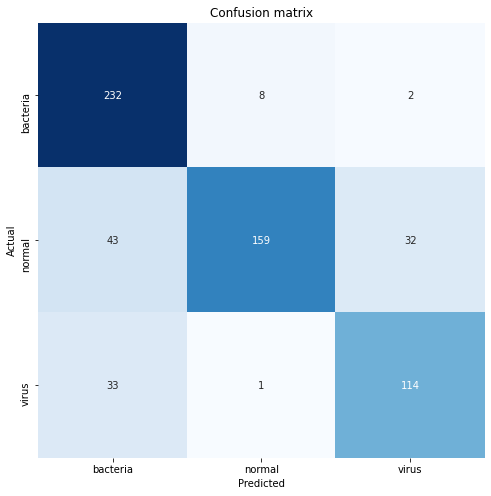

In [ ]:
classnames = ['bacteria', 'normal', 'virus']
plt.figure(figsize=(8,8))
plt.title('Confusion matrix')
sns.heatmap(cm, cbar=False, xticklabels=classnames, yticklabels=classnames, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

According to the confusion matrix above, we can see that 33 virus x-ray images are predicted as bacteria. This is probably because the two pneumonia types are quite difficult to distinguish. But well, at least our model is able to predict pneumonia caused by bacteria pretty well since 232 out of 242 samples are classified correctly.


#Performance Evaluation
---
From Confusion Matrix we can calculate Performance parameters of the model :


###Bacteria
*   True Positives for Bacteria  = 232
*   False Negatives for Bacteria = 10
*   False Positives for Bacteria = 76
*   True Negatives for Bacteria  = 306

###Normal 
*   True Positives for Normal = 159
*   False Negatives for Normal = 75
*   False Positives for Normal = 9
*   True Negatives for Normal = 381

##Virus
*   True Postives for Virus = 114
*   False Negatives for Virus = 34
*   False Positives for Virus = 34
*   True Negatives for Virus = 442

On the basis of this parameters obtained from Confusion Matrix we can calculate Precision, Recall and Specificity for different classes as follows..


1. Overall_Accuracy = Sum of True Postives / (Total no. of classifications)
2. Precision for Bacteria = True Positive of Bacteria / (True Positive of Bacteria+ False Positives of Bacteria)
3. Precision for Normal = True Positive of Normal /(True Positive of Normal+ False Positives of Normal)
4. Precision for Virus = True Positive of Virus / (True Positive of Virus+ False Positives of Virus)
5. Recall for Bacteria = True Positive of Bacteria / (True Positive of Bacteria + False Negatives of Bacteria)




In [ ]:
#Calculating Overall Accuracy
Overall_accuracy = (232+159+114) / (232+8+2+43+159+32+33+1+114)
print("1. Overall accuracy of the classifier is: {}".format(Overall_accuracy))

#Calculating Precision for Various Classes
#Bacteria
precision_b = 232 / (232+76)
print("2. Precision of Bacteria is {}".format(precision_b))
#Normal
precision_n = 159 / (159+9)
print("3. Precision of Normal is {}".format(precision_n))
#Virus
precision_v = 114 / (114+34)
print("4. Precision of Virus is {}".format(precision_v))

#Calculating Recall for Various Classes
#Bacteria
recall_b = 232 / (232+10)
print("5. Recall of Bacteria is {}".format(recall_b))
#Normal
recall_n = 159 / (159+75)
print("6. Recall of Normal is {}".format(recall_n))
#Virus
recall_v = 114 / (114+34)
print("7. Recall of Virus is {}".format(recall_v))

1. Overall accuracy of the classifier is: 0.8092948717948718
2. Precision of Bacteria is 0.7532467532467533
3. Precision of Normal is 0.9464285714285714
4. Precision of Virus is 0.7702702702702703
5. Recall of Bacteria is 0.9586776859504132
6. Recall of Normal is 0.6794871794871795
7. Recall of Virus is 0.7702702702702703


##Results
1. Overall accuracy of the classifier is = 0.8092948717948718
2. Precision of Bacteria class is =  0.7532467532467533
3. Precision of Normal class is = 0.9464285714285714
4. Precision of Virus class is = 0.7702702702702703
5. Recall of Bacteria class is = 0.9586776859504132
6. Recall of Normal class is = 0.6794871794871795
7. Recall of Virus class is = 0.7702702702702703

#Testing a Single Image

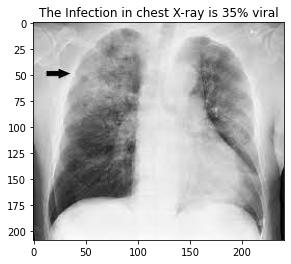

In [ ]:
from keras.models import load_model
model = load_model("/content/gdrive/MyDrive/Colab Notebooks/Project.h5")
image_path = "/content/download.jpg"
test_image = cv2.resize(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE),(200,200))


test_image = np.array(test_image).reshape( -1, 200, 200, 1)

prediction = model.predict({'input_1': test_image })
predict = {'bacterial':0,'normal':0,'viral':0}
predict['bacterial']=prediction[0][0]
predict['normal']=prediction[0][1]
predict['viral']=prediction[0][2]
keymax = max(predict,key= lambda x: predict[x])
percentage = predict[keymax]*100

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(image_path)
if keymax == "viral" or keymax=="bacterial":
  plt.title("The Infection in chest X-ray is {}% {}".format(round(percentage),keymax))
else:
  plt.title("The X-ray is {} % normal".format(round(percentage)))
imgplot = plt.imshow(img)
plt.show()


#print("The infection in chest x-ray looks like {} and i am {} percent confident".format(keymax,round(percentage)))
